# Dual-form ridge training of bistable attractor

2D limit cycle demo, varying speed and radius.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso

from aux import get_flow
from kernels import make_psi_rand_sgm
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 15)
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

DT = .001

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj(x_stars, alphas, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], us[ct, :], x_stars, alphas)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

def train(data, x_stars, lam=1e-8):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=lam, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

In [3]:
def plot_quivers(x_stars_all, alphas_all, u=None, arrow_scale=.5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, x_stars_all[0], alphas_all[0])
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    
    for x_star, alpha in zip(x_stars_all[0], alphas_all[0]):
        axs[1].scatter(*x_star, c='r')
        axs[1].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, x_stars_all[-1], alphas_all[-1])
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[2].scatter(*x_star, c='r')
        axs[2].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

    quiver(axs[3], flow_post-flow_base, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[3].scatter(*x_star, c='r')
        axs[3].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs

Target flows at specific locations

In [4]:
# data
x_tildes = np.array([[0, -1.], [0, 1]])
v_tildes = np.zeros(x_tildes.shape)

u_tildes = np.tile(np.array([0., 0]), (len(x_tildes), 1))

data = np.concatenate([x_tildes, v_tildes, u_tildes], axis=1)

## Ridge training

In [5]:
# support states
n_star = 2
x_stars = np.array([[0, -1.], [0, 1]])

lam = 1e-10
alphas = train(data, x_stars, lam)

irnd = np.random.permutation(len(x_stars))
x_stars = x_stars[irnd, :]
alphas = alphas[irnd, :]

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)

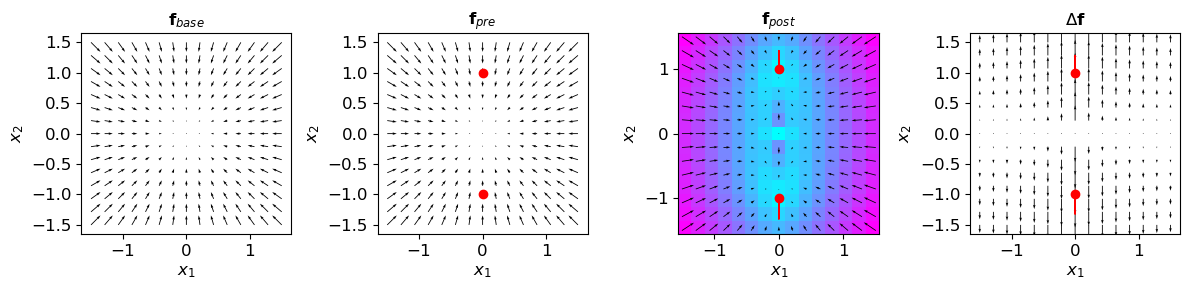

In [8]:
# plot flow fields
x_stars_all = [x_stars, x_stars]
alphas_all = [0*alphas, alphas]
fig, axs = plot_quivers(x_stars_all, alphas_all, arrow_scale=.3, u=np.array([0., 0]))

flow_post = get_flow(F_POST, RX, u=np.array([0., 0]))
extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
axs[2].xaxis.tick_bottom()

fig.savefig('ms/s2_bistable_ridge_flow.svg')

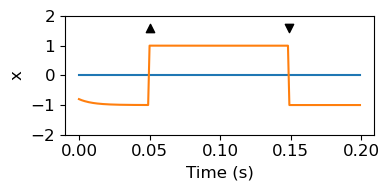

In [19]:
# simulated trajecs using ridge-trained system
t = np.arange(0, .2, DT)

us = np.zeros((len(t), D))
it_pos = int(np.round(.05//DT))
us[it_pos, 1] = .02/DT

it_neg = int(np.round(.15//DT))
us[it_neg, 1] = -.02/DT

x_init = np.array([0, -.8])
xs = smlt_trj(x_stars, alphas, x_init, t, us)

fig, ax = plt.subplots(1, 1, figsize=(4, 2), tight_layout=True)

ax.plot(t, xs)
set_plot(ax, y_lim=(-2, 2), x_label='Time (s)', y_label='x')

ax.scatter(it_pos*DT, 1.6, marker='^', c='k')
ax.scatter(it_neg*DT, 1.6, marker='v', c='k')

fig.savefig('ms/s2_bistable_ridge_trajecs.svg')